In [1]:
import os
import glob
import pandas as pd
import numpy as np
import pytz
import re
from tqdm import tqdm

# ====== Paths ======
SRC_DIR = "data sets"
OUT_DIR = "prep_output"
os.makedirs(OUT_DIR, exist_ok=True)

# ====== Load and Clean One CSV ======
def load_single(path: str) -> pd.DataFrame:
    name = os.path.basename(path)
    year = int(name[:4])
    try:
        floor = int(name.split("Floor")[1].split(".")[0])
    except Exception:
        floor = None

    cols = pd.read_csv(path, nrows=1).columns.str.strip()
    print(f"📄 {name} columns: {cols.tolist()}")

    possible_names = ["Timestamp", "Time", "Date", "Datetime", "date", "time"]
    date_col = next((col for col in cols if any(p.lower() in col.lower() for p in possible_names)), None)

    if not date_col:
        raise ValueError(f"❌ {name}: No recognizable datetime column found.")

    df = pd.read_csv(path).rename(columns=lambda x: x.strip())
    print(f"🧪 Preview [{name}] date_col='{date_col}':\n", df[[date_col]].head())

    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.dropna(subset=[date_col])
    df = df.set_index(date_col).sort_index()

    try:
        df.index = df.index.tz_localize("Asia/Bangkok", ambiguous="infer")
    except TypeError:
        if df.index.tz is None:
            df.index = df.index.tz_localize("Asia/Bangkok")
        else:
            df.index = df.index.tz_convert("Asia/Bangkok")

    df = df[~df.index.duplicated(keep='first')].ffill().bfill()
    df["Year"] = year
    if floor is not None:
        df["Floor"] = floor

    print(f"✅ Loaded {name}: shape={df.shape}, datetime_col='{date_col}'")
    return df

# ====== Outlier Clipping ======
def clip_outliers(df: pd.DataFrame) -> pd.DataFrame:
    power_cols = [c for c in df.columns if "(kW)" in c]
    lux_cols = [c for c in df.columns if "(lux)" in c]
    df[power_cols] = df[power_cols].clip(lower=0)
    df[lux_cols] = df[lux_cols].clip(upper=50000)
    return df

# ====== Load All CSVs ======
frames = []
for path in tqdm(sorted(glob.glob(os.path.join(SRC_DIR, "*.csv")))):
    try:
        df_single = load_single(path)
        if df_single is not None:
            frames.append(df_single)
    except Exception as e:
        print(f"⚠ Failed to load {path}: {e}")

if not frames:
    raise RuntimeError("❌ No valid CSVs loaded!")

full = pd.concat(frames).pipe(clip_outliers).sort_index()
print(f"🔧 Combined shape: {full.shape}")

# ====== Identify Power Columns ======
power_cols = [c for c in full.columns if "(kW)" in c]
full["TotalLoad_kW"] = full[power_cols].sum(axis=1)
full["FloorLoad_kW"] = full.groupby("Floor")[power_cols].transform("sum").sum(axis=1)

# ====== Zone-wise Summaries ======
zone_cols = {}
for col in power_cols:
    match = re.match(r"(z\d+)_", col)
    if match:
        zone = match.group(1)
        zone_cols.setdefault(zone, []).append(col)

for zone, cols in zone_cols.items():
    full[f"{zone}_Load_kW"] = full[cols].sum(axis=1)

# ====== Add Synthetic Outdoor Temperature (Bangkok style) ======
print("🌤 Generating synthetic outdoor temperature data...")
start, end = full.index.min(), full.index.max()
hours = int((end - start) / pd.Timedelta(hours=1)) + 1
dt_range = pd.date_range(start=start, periods=hours, freq='H', tz="Asia/Bangkok")
daily_cycle = 4 * np.sin(2 * np.pi * (dt_range.hour - 6) / 24)
seasonal_cycle = 2 * np.sin(2 * np.pi * (dt_range.dayofyear - 100) / 365)
outdoor_temp = 28 + daily_cycle + seasonal_cycle + np.random.normal(0, 0.5, size=hours)
outdoor_temp = np.clip(outdoor_temp, 20, 40)
outdoor_series = pd.Series(outdoor_temp, index=dt_range, name="OutdoorTemp_C")

# Align with full's index and merge in
outdoor_aligned = outdoor_series.reindex(full.index, method='nearest')
full["OutdoorTemp_C"] = outdoor_aligned

# ====== Hourly/Daily Aggregation ======
hourly = full.resample("1H").mean(numeric_only=True)
daily = full.resample("1D").mean(numeric_only=True)

hourly["TotalLoad_kW"] = hourly[power_cols].sum(axis=1)
daily["TotalLoad_kW"] = daily[power_cols].sum(axis=1)

hourly["FloorLoad_kW"] = hourly.groupby("Floor")[power_cols].transform("sum").sum(axis=1)
daily["FloorLoad_kW"] = daily.groupby("Floor")[power_cols].transform("sum").sum(axis=1)

for zone, cols in zone_cols.items():
    hourly[f"{zone}_Load_kW"] = hourly[cols].sum(axis=1)
    daily[f"{zone}_Load_kW"] = daily[cols].sum(axis=1)

# Add synthetic outdoor temp to hourly/daily
hourly["OutdoorTemp_C"] = hourly.index.map(outdoor_series.reindex(hourly.index, method='nearest'))
daily["OutdoorTemp_C"] = daily.index.map(outdoor_series.reindex(daily.index, method='nearest'))

# ====== Save Everything ======
full.to_parquet(os.path.join(OUT_DIR, "cubems_clean_with_zones.parquet"))
hourly.to_parquet(os.path.join(OUT_DIR, "cubems_hourly_with_zones.parquet"))
daily.to_parquet(os.path.join(OUT_DIR, "cubems_daily_with_zones.parquet"))
full.head(1000).to_csv(os.path.join(OUT_DIR, "sample_preview.csv"))

# ====== Show First 10 Rows ======
pd.set_option("display.max_columns", None)
print("\n🔍 First 10 rows of final dataset:")
print(full.head(10))

print("\n💾 Saved all datasets in:", OUT_DIR)

  0%|          | 0/14 [00:00<?, ?it/s]

📄 2018Floor1.csv columns: ['Date', 'z1_Light(kW)', 'z1_Plug(kW)', 'z2_AC1(kW)', 'z2_AC2(kW)', 'z2_AC3(kW)', 'z2_AC4(kW)', 'z2_Light(kW)', 'z2_Plug(kW)', 'z3_Light(kW)', 'z3_Plug(kW)', 'z4_Light(kW)']


  7%|▋         | 1/14 [00:00<00:05,  2.30it/s]

🧪 Preview [2018Floor1.csv] date_col='Date':
                   Date
0  2018-07-01 00:00:00
1  2018-07-01 00:01:00
2  2018-07-01 00:02:00
3  2018-07-01 00:03:00
4  2018-07-01 00:04:00
✅ Loaded 2018Floor1.csv: shape=(264960, 13), datetime_col='Date'
📄 2018Floor2.csv columns: ['Date', 'z1_AC1(kW)', 'z1_Light(kW)', 'z1_Plug(kW)', 'z1_S1(degC)', 'z1_S1(RH%)', 'z1_S1(lux)', 'z2_AC1(kW)', 'z2_AC2(kW)', 'z2_AC3(kW)', 'z2_AC4(kW)', 'z2_AC5(kW)', 'z2_AC6(kW)', 'z2_AC7(kW)', 'z2_AC8(kW)', 'z2_AC9(kW)', 'z2_AC10(kW)', 'z2_AC11(kW)', 'z2_AC12(kW)', 'z2_AC13(kW)', 'z2_AC14(kW)', 'z2_Light(kW)', 'z2_Plug(kW)', 'z2_S1(degC)', 'z2_S1(RH%)', 'z2_S1(lux)', 'z3_Light(kW)', 'z3_Plug(kW)', 'z3_S1(degC)', 'z3_S1(RH%)', 'z3_S1(lux)', 'z4_AC1(kW)', 'z4_Light(kW)', 'z4_Plug(kW)', 'z4_S1(degC)', 'z4_S1(RH%)', 'z4_S1(lux)']
🧪 Preview [2018Floor2.csv] date_col='Date':
                   Date
0  2018-07-01 00:00:00
1  2018-07-01 00:01:00
2  2018-07-01 00:02:00
3  2018-07-01 00:03:00
4  2018-07-01 00:04:00


 14%|█▍        | 2/14 [00:01<00:07,  1.55it/s]

✅ Loaded 2018Floor2.csv: shape=(264960, 38), datetime_col='Date'
📄 2018Floor3.csv columns: ['Date', 'z1_AC1(kW)', 'z1_AC2(kW)', 'z1_AC3(kW)', 'z1_AC4(kW)', 'z1_Light(kW)', 'z1_Plug(kW)', 'z1_S1(degC)', 'z1_S1(RH%)', 'z1_S1(lux)', 'z2_AC1(kW)', 'z2_Light(kW)', 'z2_Plug(kW)', 'z2_S1(degC)', 'z2_S1(RH%)', 'z2_S1(lux)', 'z3_Light(kW)', 'z3_Plug(kW)', 'z4_AC1(kW)', 'z4_Light(kW)', 'z4_Plug(kW)', 'z4_S1(degC)', 'z4_S1(RH%)', 'z4_S1(lux)', 'z5_AC1(kW)', 'z5_Light(kW)', 'z5_Plug(kW)', 'z5_S1(degC)', 'z5_S1(RH%)', 'z5_S1(lux)']
🧪 Preview [2018Floor3.csv] date_col='Date':
                   Date
0  2018-07-01 00:00:00
1  2018-07-01 00:01:00
2  2018-07-01 00:02:00
3  2018-07-01 00:03:00
4  2018-07-01 00:04:00


 21%|██▏       | 3/14 [00:01<00:07,  1.53it/s]

✅ Loaded 2018Floor3.csv: shape=(264960, 31), datetime_col='Date'
📄 2018Floor4.csv columns: ['Date', 'z1_AC1(kW)', 'z1_AC2(kW)', 'z1_AC3(kW)', 'z1_AC4(kW)', 'z1_Light(kW)', 'z1_Plug(kW)', 'z1_S1(degC)', 'z1_S1(RH%)', 'z1_S1(lux)', 'z2_AC1(kW)', 'z2_Light(kW)', 'z2_Plug(kW)', 'z2_S1(degC)', 'z2_S1(RH%)', 'z2_S1(lux)', 'z3_Light(kW)', 'z3_Plug(kW)', 'z4_AC1(kW)', 'z4_Light(kW)', 'z4_Plug(kW)', 'z4_S1(degC)', 'z4_S1(RH%)', 'z4_S1(lux)', 'z5_AC1(kW)', 'z5_Light(kW)', 'z5_Plug(kW)', 'z5_S1(degC)', 'z5_S1(RH%)', 'z5_S1(lux)']
🧪 Preview [2018Floor4.csv] date_col='Date':
                   Date
0  2018-07-01 00:00:00
1  2018-07-01 00:01:00
2  2018-07-01 00:02:00
3  2018-07-01 00:03:00
4  2018-07-01 00:04:00


 29%|██▊       | 4/14 [00:02<00:06,  1.50it/s]

✅ Loaded 2018Floor4.csv: shape=(264960, 31), datetime_col='Date'
📄 2018Floor5.csv columns: ['Date', 'z1_AC1(kW)', 'z1_AC2(kW)', 'z1_AC3(kW)', 'z1_AC4(kW)', 'z1_Light(kW)', 'z1_Plug(kW)', 'z1_S1(degC)', 'z1_S1(RH%)', 'z1_S1(lux)', 'z2_AC1(kW)', 'z2_Light(kW)', 'z2_Plug(kW)', 'z2_S1(degC)', 'z2_S1(RH%)', 'z2_S1(lux)', 'z3_Light(kW)', 'z3_Plug(kW)', 'z4_AC1(kW)', 'z4_Light(kW)', 'z4_Plug(kW)', 'z4_S1(degC)', 'z4_S1(RH%)', 'z4_S1(lux)', 'z5_AC1(kW)', 'z5_Light(kW)', 'z5_Plug(kW)', 'z5_S1(degC)', 'z5_S1(RH%)', 'z5_S1(lux)']
🧪 Preview [2018Floor5.csv] date_col='Date':
                   Date
0  2018-07-01 00:00:00
1  2018-07-01 00:01:00
2  2018-07-01 00:02:00
3  2018-07-01 00:03:00
4  2018-07-01 00:04:00


 36%|███▌      | 5/14 [00:03<00:06,  1.49it/s]

✅ Loaded 2018Floor5.csv: shape=(264960, 31), datetime_col='Date'
📄 2018Floor6.csv columns: ['Date', 'z1_AC1(kW)', 'z1_Light(kW)', 'z1_Plug(kW)', 'z1_S1(degC)', 'z1_S1(RH%)', 'z1_S1(lux)', 'z2_AC1(kW)', 'z2_Light(kW)', 'z2_Plug(kW)', 'z2_S1(degC)', 'z2_S1(RH%)', 'z2_S1(lux)', 'z3_Light(kW)', 'z3_Plug(kW)', 'z4_AC1(kW)', 'z4_AC2(kW)', 'z4_AC3(kW)', 'z4_AC4(kW)', 'z4_Light(kW)', 'z4_Plug(kW)', 'z4_S1(degC)', 'z4_S1(RH%)', 'z4_S1(lux)', 'z5_AC1(kW)', 'z5_Light(kW)', 'z5_Plug(kW)', 'z5_S1(degC)', 'z5_S1(RH%)', 'z5_S1(lux)']
🧪 Preview [2018Floor6.csv] date_col='Date':
                   Date
0  2018-07-01 00:00:00
1  2018-07-01 00:01:00
2  2018-07-01 00:02:00
3  2018-07-01 00:03:00
4  2018-07-01 00:04:00


 43%|████▎     | 6/14 [00:03<00:05,  1.48it/s]

✅ Loaded 2018Floor6.csv: shape=(264960, 31), datetime_col='Date'
📄 2018Floor7.csv columns: ['Date', 'z1_AC1(kW)', 'z1_AC2(kW)', 'z1_AC3(kW)', 'z1_AC4(kW)', 'z1_Light(kW)', 'z1_Plug(kW)', 'z1_S1(degC)', 'z1_S1(RH%)', 'z1_S1(lux)', 'z2_AC1(kW)', 'z2_Light(kW)', 'z2_Plug(kW)', 'z2_S1(degC)', 'z2_S1(RH%)', 'z2_S1(lux)', 'z3_Light(kW)', 'z3_Plug(kW)', 'z4_AC1(kW)', 'z4_Light(kW)', 'z4_Plug(kW)', 'z4_S1(degC)', 'z4_S1(RH%)', 'z4_S1(lux)', 'z5_AC1(kW)', 'z5_Light(kW)', 'z5_Plug(kW)', 'z5_S1(degC)', 'z5_S1(RH%)', 'z5_S1(lux)']
🧪 Preview [2018Floor7.csv] date_col='Date':
                   Date
0  2018-07-01 00:00:00
1  2018-07-01 00:01:00
2  2018-07-01 00:02:00
3  2018-07-01 00:03:00
4  2018-07-01 00:04:00


 50%|█████     | 7/14 [00:04<00:04,  1.46it/s]

✅ Loaded 2018Floor7.csv: shape=(264960, 31), datetime_col='Date'
📄 2019Floor1.csv columns: ['Date', 'z1_Light(kW)', 'z1_Plug(kW)', 'z2_AC1(kW)', 'z2_AC2(kW)', 'z2_AC3(kW)', 'z2_AC4(kW)', 'z2_Light(kW)', 'z2_Plug(kW)', 'z3_Light(kW)', 'z3_Plug(kW)', 'z4_Light(kW)']
🧪 Preview [2019Floor1.csv] date_col='Date':
                   Date
0  2019-01-01 00:00:00
1  2019-01-01 00:01:00
2  2019-01-01 00:02:00
3  2019-01-01 00:03:00
4  2019-01-01 00:04:00


 57%|█████▋    | 8/14 [00:05<00:04,  1.43it/s]

✅ Loaded 2019Floor1.csv: shape=(525600, 13), datetime_col='Date'
📄 2019Floor2.csv columns: ['Date', 'z1_AC1(kW)', 'z1_Light(kW)', 'z1_Plug(kW)', 'z1_S1(degC)', 'z1_S1(RH%)', 'z1_S1(lux)', 'z2_AC1(kW)', 'z2_AC2(kW)', 'z2_AC3(kW)', 'z2_AC4(kW)', 'z2_AC5(kW)', 'z2_AC6(kW)', 'z2_AC7(kW)', 'z2_AC8(kW)', 'z2_AC9(kW)', 'z2_AC10(kW)', 'z2_AC11(kW)', 'z2_AC12(kW)', 'z2_AC13(kW)', 'z2_AC14(kW)', 'z2_Light(kW)', 'z2_Plug(kW)', 'z2_S1(degC)', 'z2_S1(RH%)', 'z2_S1(lux)', 'z3_Light(kW)', 'z3_Plug(kW)', 'z3_S1(degC)', 'z3_S1(RH%)', 'z3_S1(lux)', 'z4_AC1(kW)', 'z4_Light(kW)', 'z4_Plug(kW)', 'z4_S1(degC)', 'z4_S1(RH%)', 'z4_S1(lux)']
🧪 Preview [2019Floor2.csv] date_col='Date':
                   Date
0  2019-01-01 00:00:00
1  2019-01-01 00:01:00
2  2019-01-01 00:02:00
3  2019-01-01 00:03:00
4  2019-01-01 00:04:00


 64%|██████▍   | 9/14 [00:06<00:04,  1.03it/s]

✅ Loaded 2019Floor2.csv: shape=(525600, 38), datetime_col='Date'
📄 2019Floor3.csv columns: ['Date', 'z1_AC1(kW)', 'z1_AC2(kW)', 'z1_AC3(kW)', 'z1_AC4(kW)', 'z1_Light(kW)', 'z1_Plug(kW)', 'z1_S1(degC)', 'z1_S1(RH%)', 'z1_S1(lux)', 'z2_AC1(kW)', 'z2_Light(kW)', 'z2_Plug(kW)', 'z2_S1(degC)', 'z2_S1(RH%)', 'z2_S1(lux)', 'z3_Light(kW)', 'z3_Plug(kW)', 'z4_AC1(kW)', 'z4_Light(kW)', 'z4_Plug(kW)', 'z4_S1(degC)', 'z4_S1(RH%)', 'z4_S1(lux)', 'z5_AC1(kW)', 'z5_Light(kW)', 'z5_Plug(kW)', 'z5_S1(degC)', 'z5_S1(RH%)', 'z5_S1(lux)']
🧪 Preview [2019Floor3.csv] date_col='Date':
                   Date
0  2019-01-01 00:00:00
1  2019-01-01 00:01:00
2  2019-01-01 00:02:00
3  2019-01-01 00:03:00
4  2019-01-01 00:04:00


 71%|███████▏  | 10/14 [00:08<00:04,  1.08s/it]

✅ Loaded 2019Floor3.csv: shape=(525600, 31), datetime_col='Date'
📄 2019Floor4.csv columns: ['Date', 'z1_AC1(kW)', 'z1_AC2(kW)', 'z1_AC3(kW)', 'z1_AC4(kW)', 'z1_Light(kW)', 'z1_Plug(kW)', 'z1_S1(degC)', 'z1_S1(RH%)', 'z1_S1(lux)', 'z2_AC1(kW)', 'z2_Light(kW)', 'z2_Plug(kW)', 'z2_S1(degC)', 'z2_S1(RH%)', 'z2_S1(lux)', 'z3_Light(kW)', 'z3_Plug(kW)', 'z4_AC1(kW)', 'z4_Light(kW)', 'z4_Plug(kW)', 'z4_S1(degC)', 'z4_S1(RH%)', 'z4_S1(lux)', 'z5_AC1(kW)', 'z5_Light(kW)', 'z5_Plug(kW)', 'z5_S1(degC)', 'z5_S1(RH%)', 'z5_S1(lux)']
🧪 Preview [2019Floor4.csv] date_col='Date':
                   Date
0  2019-01-01 00:00:00
1  2019-01-01 00:01:00
2  2019-01-01 00:02:00
3  2019-01-01 00:03:00
4  2019-01-01 00:04:00


 79%|███████▊  | 11/14 [00:09<00:03,  1.15s/it]

✅ Loaded 2019Floor4.csv: shape=(525600, 31), datetime_col='Date'
📄 2019Floor5.csv columns: ['Date', 'z1_AC1(kW)', 'z1_AC2(kW)', 'z1_AC3(kW)', 'z1_AC4(kW)', 'z1_Light(kW)', 'z1_Plug(kW)', 'z1_S1(degC)', 'z1_S1(RH%)', 'z1_S1(lux)', 'z2_AC1(kW)', 'z2_Light(kW)', 'z2_Plug(kW)', 'z2_S1(degC)', 'z2_S1(RH%)', 'z2_S1(lux)', 'z3_Light(kW)', 'z3_Plug(kW)', 'z4_AC1(kW)', 'z4_Light(kW)', 'z4_Plug(kW)', 'z4_S1(degC)', 'z4_S1(RH%)', 'z4_S1(lux)', 'z5_AC1(kW)', 'z5_Light(kW)', 'z5_Plug(kW)', 'z5_S1(degC)', 'z5_S1(RH%)', 'z5_S1(lux)']
🧪 Preview [2019Floor5.csv] date_col='Date':
                   Date
0  2019-01-01 00:00:00
1  2019-01-01 00:01:00
2  2019-01-01 00:02:00
3  2019-01-01 00:03:00
4  2019-01-01 00:04:00


 86%|████████▌ | 12/14 [00:10<00:02,  1.20s/it]

✅ Loaded 2019Floor5.csv: shape=(525600, 31), datetime_col='Date'
📄 2019Floor6.csv columns: ['Date', 'z1_AC1(kW)', 'z1_Light(kW)', 'z1_Plug(kW)', 'z1_S1(degC)', 'z1_S1(RH%)', 'z1_S1(lux)', 'z2_AC1(kW)', 'z2_Light(kW)', 'z2_Plug(kW)', 'z2_S1(degC)', 'z2_S1(RH%)', 'z2_S1(lux)', 'z3_Light(kW)', 'z3_Plug(kW)', 'z4_AC1(kW)', 'z4_AC2(kW)', 'z4_AC3(kW)', 'z4_AC4(kW)', 'z4_Light(kW)', 'z4_Plug(kW)', 'z4_S1(degC)', 'z4_S1(RH%)', 'z4_S1(lux)', 'z5_AC1(kW)', 'z5_Light(kW)', 'z5_Plug(kW)', 'z5_S1(degC)', 'z5_S1(RH%)', 'z5_S1(lux)']
🧪 Preview [2019Floor6.csv] date_col='Date':
                   Date
0  2019-01-01 00:00:00
1  2019-01-01 00:01:00
2  2019-01-01 00:02:00
3  2019-01-01 00:03:00
4  2019-01-01 00:04:00


 93%|█████████▎| 13/14 [00:11<00:01,  1.16s/it]

✅ Loaded 2019Floor6.csv: shape=(424168, 31), datetime_col='Date'
📄 2019Floor7.csv columns: ['Date', 'z1_AC1(kW)', 'z1_AC2(kW)', 'z1_AC3(kW)', 'z1_AC4(kW)', 'z1_Light(kW)', 'z1_Plug(kW)', 'z1_S1(degC)', 'z1_S1(RH%)', 'z1_S1(lux)', 'z2_AC1(kW)', 'z2_Light(kW)', 'z2_Plug(kW)', 'z2_S1(degC)', 'z2_S1(RH%)', 'z2_S1(lux)', 'z3_Light(kW)', 'z3_Plug(kW)', 'z4_AC1(kW)', 'z4_Light(kW)', 'z4_Plug(kW)', 'z4_S1(degC)', 'z4_S1(RH%)', 'z4_S1(lux)', 'z5_AC1(kW)', 'z5_Light(kW)', 'z5_Plug(kW)', 'z5_S1(degC)', 'z5_S1(RH%)', 'z5_S1(lux)']
🧪 Preview [2019Floor7.csv] date_col='Date':
                   Date
0  2019-01-01 00:00:00
1  2019-01-01 00:01:00
2  2019-01-01 00:02:00
3  2019-01-01 00:03:00
4  2019-01-01 00:04:00


100%|██████████| 14/14 [00:13<00:00,  1.05it/s]

✅ Loaded 2019Floor7.csv: shape=(525600, 31), datetime_col='Date'


🔧 Combined shape: (5432488, 50)
🌤 Generating synthetic outdoor temperature data...


C:\Users\welcome\AppData\Local\Temp\ipykernel_3208\329473772.py:99: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dt_range = pd.date_range(start=start, periods=hours, freq='H', tz="Asia/Bangkok")
C:\Users\welcome\AppData\Local\Temp\ipykernel_3208\329473772.py:111: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly = full.resample("1H").mean(numeric_only=True)



🔍 First 10 rows of final dataset:
                           z1_Light(kW)  z1_Plug(kW)  z2_AC1(kW)  z2_AC2(kW)  \
Date                                                                           
2018-07-01 00:00:00+07:00         12.94        18.56       45.24        0.01   
2018-07-01 00:00:00+07:00          0.01         0.15        1.08        0.00   
2018-07-01 00:00:00+07:00          0.00         0.31        0.00         NaN   
2018-07-01 00:00:00+07:00          0.00         0.03        0.00         NaN   
2018-07-01 00:00:00+07:00          0.00         0.02        0.00         NaN   
2018-07-01 00:00:00+07:00          0.00         0.22        0.00         NaN   
2018-07-01 00:00:00+07:00          0.34         0.17        0.00         NaN   
2018-07-01 00:01:00+07:00         12.97        18.55       45.28        0.02   
2018-07-01 00:01:00+07:00          0.00         0.03        0.00         NaN   
2018-07-01 00:01:00+07:00          0.00         0.02        0.00         NaN   

    

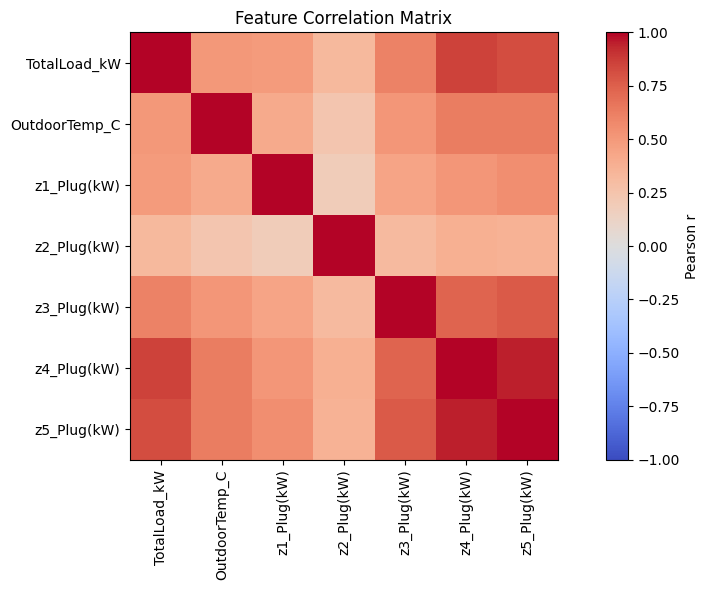

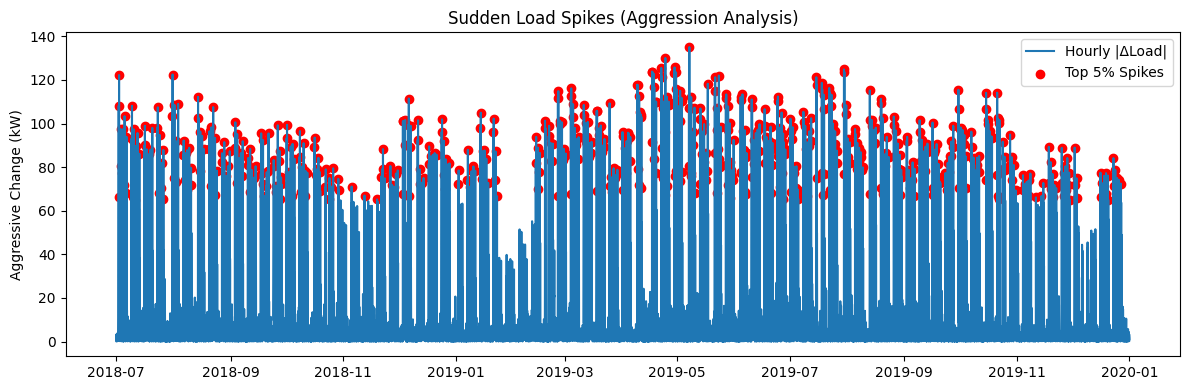

C:\Users\welcome\AppData\Local\Temp\ipykernel_3208\3089576723.py:57: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly["MeanIndoorTemp"] = full[temp_cols].resample("1H").mean().mean(axis=1)


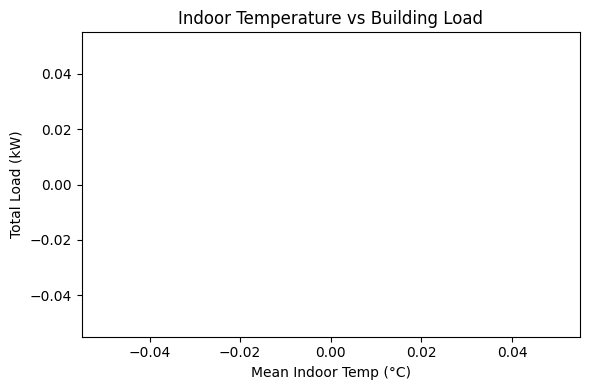

C:\Users\welcome\AppData\Local\Temp\ipykernel_3208\3089576723.py:72: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  building_daily.index = building_daily.index.to_period('D').to_timestamp()


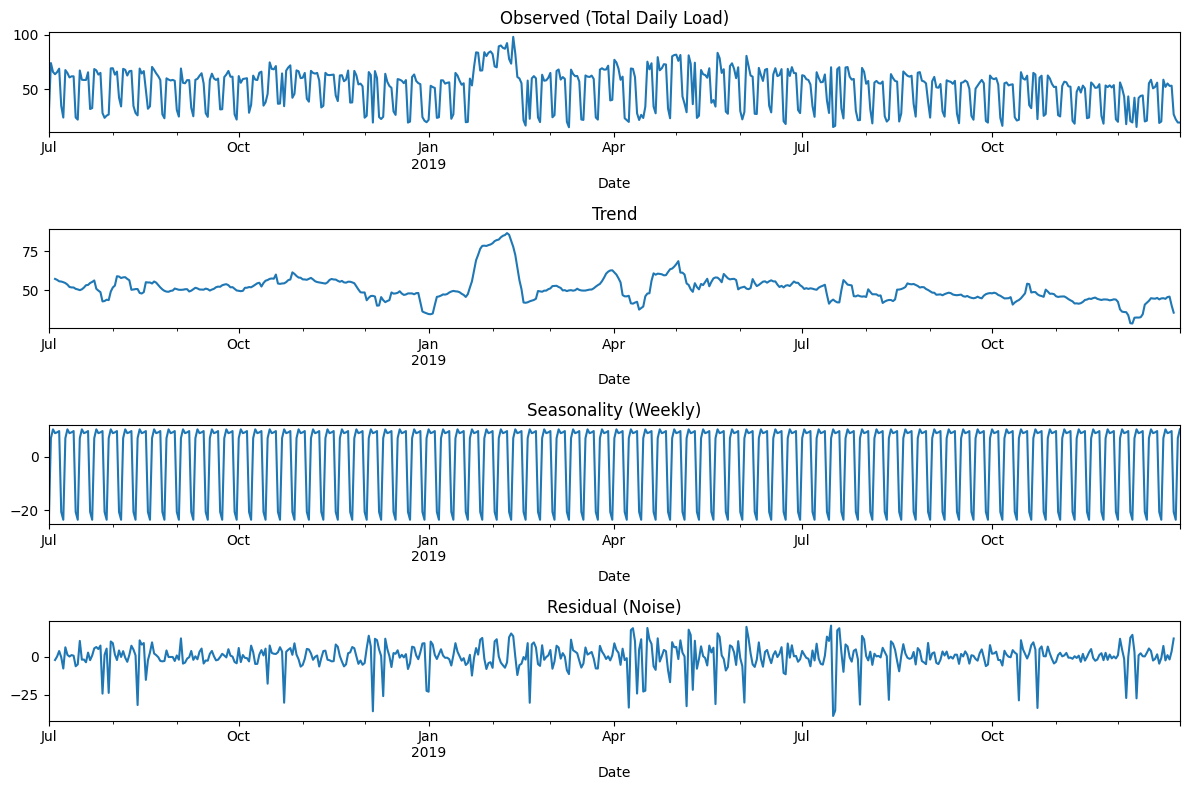

✅ Analysis complete. Visualizations generated!


In [4]:
# ===== CU-BEMS Analysis Script =====

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Load preprocessed datasets
full = pd.read_parquet("prep_output/cubems_clean_with_zones.parquet")
hourly = pd.read_parquet("prep_output/cubems_hourly_with_zones.parquet")
daily = pd.read_parquet("prep_output/cubems_daily_with_zones.parquet")

# ===================== CORRELATION ANALYSIS =====================

# Choose relevant columns
corr_vars = ["TotalLoad_kW", "OutdoorTemp_C"] + \
            [c for c in full.columns if ("Temp" in c and "(C)" in c)] + \
            [c for c in full.columns if "Plug(kW)" in c or "AC(kW)" in c]

# Drop NA rows to prevent noise
corr_data = hourly[corr_vars].dropna()

# Correlation matrix
corr_mat = corr_data.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 6))
plt.imshow(corr_mat, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label="Pearson r")
plt.xticks(range(len(corr_mat)), corr_mat.columns, rotation=90)
plt.yticks(range(len(corr_mat)), corr_mat.columns)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

# ===================== AGGRESSION VALUE =====================

# Calculate aggressive changes (sudden jumps)
hourly["LoadChange"] = hourly["TotalLoad_kW"].diff().abs()
threshold = hourly["LoadChange"].quantile(0.95)
spikes = hourly[hourly["LoadChange"] > threshold]

# Plot aggression (top 5% spikes)
plt.figure(figsize=(12, 4))
plt.plot(hourly.index, hourly["LoadChange"], label="Hourly |ΔLoad|")
plt.scatter(spikes.index, spikes["LoadChange"], color='red', label='Top 5% Spikes')
plt.ylabel("Aggressive Change (kW)")
plt.title("Sudden Load Spikes (Aggression Analysis)")
plt.legend()
plt.tight_layout()
plt.show()

# ===================== INDOOR INFLUENCE ANALYSIS =====================

# Average indoor temp across all temp sensors
temp_cols = [c for c in full.columns if "Temp(C)" in c]
hourly["MeanIndoorTemp"] = full[temp_cols].resample("1H").mean().mean(axis=1)

# Scatter: Mean Indoor Temp vs Total Load
plt.figure(figsize=(6, 4))
plt.scatter(hourly["MeanIndoorTemp"], hourly["TotalLoad_kW"], alpha=0.5, s=10)
plt.xlabel("Mean Indoor Temp (°C)")
plt.ylabel("Total Load (kW)")
plt.title("Indoor Temperature vs Building Load")
plt.tight_layout()
plt.show()

# ===================== TIME SERIES DECOMPOSITION =====================

# Drop missing and convert to Period for smooth plotting
building_daily = daily["TotalLoad_kW"].dropna()
building_daily.index = building_daily.index.to_period('D').to_timestamp()

# Decompose with 7-day seasonality (weekly pattern)
decomp = seasonal_decompose(building_daily, model='additive', period=7)

plt.figure(figsize=(12, 8))
plt.subplot(411)
decomp.observed.plot(ax=plt.gca(), title="Observed (Total Daily Load)")
plt.subplot(412)
decomp.trend.plot(ax=plt.gca(), title="Trend")
plt.subplot(413)
decomp.seasonal.plot(ax=plt.gca(), title="Seasonality (Weekly)")
plt.subplot(414)
decomp.resid.plot(ax=plt.gca(), title="Residual (Noise)")
plt.tight_layout()
plt.show()

print("✅ Analysis complete. Visualizations generated!")